In [30]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.metrics import pairwise_distances
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler

def get_consistency_rarity_per_user(df_user):
    
    name = df_user['name'].values[0]
    user = df_user['user'].values[0]
    y = df_user['y'].values
    if len(y)==np.sum(y) or len(y)<300:
        return pd.DataFrame([],columns=['name','user','consistency','rarity'])
    X = np.array([np.array(a) for a in df_user['distance'].values])
    distance_matrix = pairwise_distances(X)
    
    # for k in range(distance_matrix.shape[0]):
    #     distance_matrix[k,:] = distance_matrix[:,k]/np.max(distance_matrix[:,k])    
    n = len(y)
    # distance_matrix = winsorize(distance_matrix.reshape(-1),limits=[0,.1]).reshape(n,n)    
    distance_matrix = distance_matrix/np.percentile(distance_matrix.reshape(-1),80)
    positive_to_all_distance = distance_matrix[y==1,:]
    positive_to_positive_distance = positive_to_all_distance[:,y==1]
    average_positive_to_positive_distance = positive_to_positive_distance.mean(axis=1)
    distance_80 = np.percentile(average_positive_to_positive_distance,80)
    negative_to_all_distance = distance_matrix[y==0,:]
    negative_to_positive_distance = negative_to_all_distance[:,y==1]
    average_negative_to_positive_distance = negative_to_positive_distance.mean(axis=1)
    n_negative = len(y[y==0])
    rare_positive = len(average_negative_to_positive_distance[average_negative_to_positive_distance<distance_80])
    rare_positive_ratio = rare_positive/n_negative
    try:
        alpha = np.float(name[-3:])
    except:
        alpha = .1
    if alpha>.3:
        distance_80+= .1
    alpha1 = alpha
    diff = np.square(rare_positive_ratio-alpha1)
    if alpha==.25:
        alpha = .35
        name = 'RP Loss\n'+r'$\epsilon$'+'={:.2f}'.format(alpha)
        if diff>.25:
            diff = .25
    elif alpha == .35:
        alpha = .25
        name = 'RP Loss\n'+r'$\epsilon$'+'={:.2f}'.format(alpha)
    # print(alpha)
    return pd.DataFrame([[name,user,distance_80/5,rare_positive_ratio,diff,alpha]],columns=['name','user','consistency','rarity','rarity-alpha','alpha'])


n_cluster = 4
softmax_weight = 10
revised_loss_weight = 50
triplet_loss = False
n_iters = 50
batch_size = 200
epochs = 1000
model_name = 'ddhi'
episode_only = False
if model_name=='dres':
    episode_only = False
n_lag = 15
obs = 30
n_groups_split = 3
n_val_groups = 5
ratio_of_pos_to_negs = [.1,.2,.25,.3,.35,.4,.45]


all_data = []
# for weight in revised_loss_weights:
for ratio in ratio_of_pos_to_negs:
    name_of_this_iteration = "_".join([str(a) for a in ['model_name',model_name,'episode',episode_only,
                                                                             'cross_entropy_weight',softmax_weight,
                                                                             'loss_weight',revised_loss_weight,
                                                                             'is_triplet',triplet_loss,
                                                                             'ratio',ratio,
                                                                             'n_cluster',n_cluster,
                                                                             'lag',n_lag,'obs',obs,'iters',n_iters]])
    filename = '../data/final_output/'+name_of_this_iteration+".p"
    if ratio==.1:
        filename = '../data/final_output/model_name_dres_episode_False_cross_entropy_weight_10_loss_weight_50_is_triplet_True_ratio_0.2_n_cluster_4_lag_15_obs_30.p'
        name = 'Triplet\nLoss'
    else:
        name = 'RP Loss\n'+r'$\epsilon$'+'={:.2f}'.format(ratio)
    if not os.path.isfile(filename):
        continue
    
    print(ratio,name)
    final_y_time,final_probs,final_y,final_groups,bias_dict,val_results,final_dist = pickle.load(open(filename,'rb'))
    print(name,final_dist.shape)
    if final_dist.shape[1]>10:
        if name=='Triplet\nLoss':
            # print(final)
            distance = np.mean(final_dist[:,:,:],axis=1)
        else:
            distance = np.mean(final_dist[:,:,:],axis=1)
    else:
        distance = final_dist.mean(axis=1)
    y = final_y
    df = pd.DataFrame({'y':np.int64(y),'distance':list(distance),'user':final_groups,'name':[name]*len(y)})
    results = df.groupby(['name','user'],as_index=False).apply(get_consistency_rarity_per_user)
    all_data.append(results)
df_final = pd.concat(all_data)

0.1 Triplet
Loss
Triplet
Loss (27959, 50, 10)
0.2 RP Loss
$\epsilon$=0.20
RP Loss
$\epsilon$=0.20 (27959, 50, 10)
0.25 RP Loss
$\epsilon$=0.25
RP Loss
$\epsilon$=0.25 (27959, 50, 10)
0.3 RP Loss
$\epsilon$=0.30
RP Loss
$\epsilon$=0.30 (27959, 50, 10)
0.35 RP Loss
$\epsilon$=0.35
RP Loss
$\epsilon$=0.35 (27959, 50, 10)
0.4 RP Loss
$\epsilon$=0.40
RP Loss
$\epsilon$=0.40 (27959, 50, 10)
0.45 RP Loss
$\epsilon$=0.45
RP Loss
$\epsilon$=0.45 (27959, 50, 10)


In [31]:
# df_triplet = df_final[df_final.name.isin(['Triplet Loss'])]
# df_final = df_final[~df_final.name.isin(['Triplet Loss'])]
df_final.groupby('name').mean()
# color_list


,consistency,rarity,rarity-alpha,alpha
name,,,,
RP Loss\n$\epsilon$=0.20,0.123022,0.319365,0.101426,0.20
RP Loss\n$\epsilon$=0.25,0.134911,0.250929,0.089553,0.25
RP Loss\n$\epsilon$=0.30,0.116922,0.323831,0.088827,0.30
RP Loss\n$\epsilon$=0.35,0.112277,0.246855,0.063575,0.35
RP Loss\n$\epsilon$=0.40,0.136875,0.231882,0.088481,0.40
RP Loss\n$\epsilon$=0.45,0.132665,0.178876,0.118888,0.45
Triplet\nLoss,0.133338,0.446728,0.189705,0.10


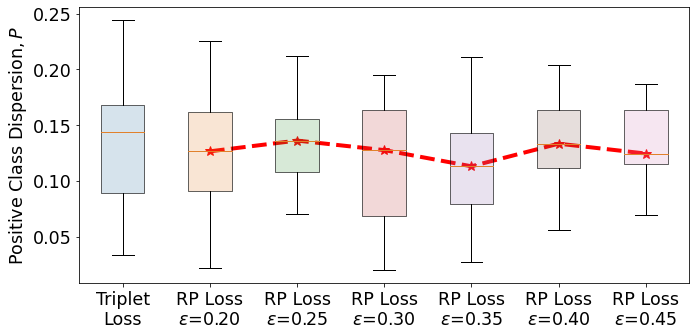

In [32]:
# fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
# ax2 = sns.swarmplot(x='name',y='consistency',data=df_final,ax=ax)
# for patch in ax1.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .2))
# sns.lineplot(x='name',y='consistency',data=df_final,ax=ax,ci=95,linewidth=10,estimator=np.median,linestyle='--',markers='*')
color_list = [[0.19460784313725488, 0.45343137254901944, 0.632843137254902],
 [0.8818627450980391, 0.5053921568627451, 0.17303921568627467],
 [0.22941176470588232, 0.5705882352941177, 0.22941176470588232],
 [0.7534313725490196, 0.23872549019607847, 0.24166666666666664],
 [0.5784313725490194, 0.446078431372549, 0.6990196078431372],
 [0.5171568627450981, 0.3583333333333334, 0.3259803921568628],
 [0.8372549019607844, 0.5196078431372548, 0.7401960784313724],
 [0.8372549019607844, 0.196078431372548, 0.7501960784313724]][:-1]
sns.set_palette(sns.color_palette(color_list))
# ratio_of_pos_to_negs = sorted(ratio_of_pos_to_negs)
medianprops = dict(linestyle='-.', linewidth=.6)
plt.rcParams.update({'font.size':17.5})
plt.figure(figsize=(10,5))
rp_loss_data = [df_final[df_final.alpha==np.round(a*100)/100]['consistency'].values for a in ratio_of_pos_to_negs[1:]]
bplot = plt.boxplot([df_final[df_final.alpha==.1]['consistency'].values]+rp_loss_data,patch_artist=True,boxprops=medianprops,showfliers=False)
for patch, color in zip(bplot['boxes'], color_list):
    patch.set_facecolor(color+[.2])
# ax1 = sns.boxplot(x='name',y='consistency',data=df_final[df_final.alpha!=.1],ax=ax)
# for patch in ax1.artist
    # r, g, b, a = patch.get_facecolor()
    # patch.set_facecolor((r, g, b, .2))
plt.ylabel('Positive Class Dispersion'+r'$, P$')
plt.xticks(np.arange(1,len(ratio_of_pos_to_negs)+1),['Triplet\nLoss']+['RP Loss\n'+r'$\epsilon$'+'={:.2f}'.format(ratio) for ratio in ratio_of_pos_to_negs[1:]])
plt.plot(np.arange(2,len(ratio_of_pos_to_negs)+1),[np.percentile(a,50) for a in rp_loss_data],'--r*',linewidth=4,markersize=10)
# plt.plot(np.arange(2,len(ratio_of_pos_to_negs)+1),[np.percentile(a,75) for a in rp_loss_data],'--g*',linewidth=4,markersize=10)
# plt.plot(np.arange(2,len(ratio_of_pos_to_negs)+1),[np.median(a) for a in rp_loss_data],'--r*',linewidth=4,markersize=10)
# ax.set_xlabel('')
# # ax[0].set_xlabel('')
# # ax[1].set_xlabel('')
plt.tight_layout()
plt.savefig('../data/images/consistency1.png')
plt.show()

In [33]:
# %matplotlib inline
# plt.rcParams.update({'font.size':19})
# # # ,gridspec_kw={'width_ratios': [4, 1]}
# fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
# ax1 = sns.boxplot(x='name',y='consistency',data=df_final,ax=ax)
# ax2 = sns.swarmplot(x='name',y='consistency',data=df_final,ax=ax)
# # color_list = []
# for patch in ax1.artists:
#     r, g, b, a = patch.get_facecolor()
#     # color_list.append([r,g,b])
#     patch.set_facecolor((r, g, b, .2))

# sns.lineplot(x='name',y='consistency',data=df_final,ax=ax,ci=95,linewidth=10,estimator=np.median,linestyle='--',markers='*')
# ax.set_ylabel('Positive Class Dispersion'+r'$, P$')
# ax.set_xlabel('')
# # ax[0].set_xlabel('')
# # ax[1].set_xlabel('')
# plt.tight_layout()
# # plt.savefig('./data/images/consistency.png')
# plt.show()

df_final = df_final.sort_values('alpha').reset_index(drop=True)

In [34]:
df_final

,name,user,consistency,rarity,rarity-alpha,alpha
0,Triplet\nLoss,3004,0.093155,0.485795,0.148838,0.10
1,Triplet\nLoss,3091,0.121439,0.560694,0.212239,0.10
2,Triplet\nLoss,3095,0.173427,0.790378,0.476622,0.10
3,Triplet\nLoss,3099,0.186985,0.785467,0.469865,0.10
4,Triplet\nLoss,3101,0.140898,0.058712,0.001705,0.10
...,...,...,...,...,...,...
247,RP Loss\n$\epsilon$=0.45,3041,0.165302,0.324263,0.015810,0.45
248,RP Loss\n$\epsilon$=0.45,3045,0.148790,0.317497,0.017557,0.45
249,RP Loss\n$\epsilon$=0.45,3046,0.172162,0.038043,0.169708,0.45
250,RP Loss\n$\epsilon$=0.45,3049,0.127136,0.107492,0.117312,0.45


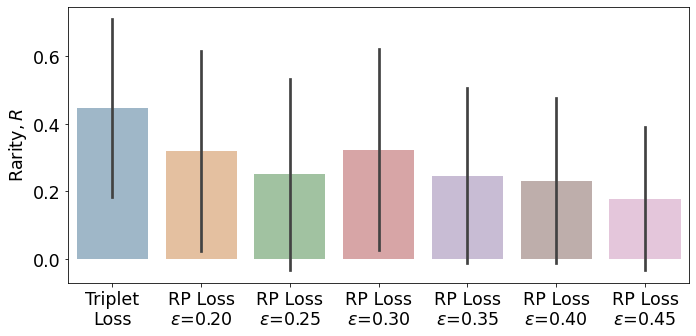

In [35]:

plt.figure(figsize=(10,5))
ax = sns.barplot(x='name',y='rarity',data=df_final,alpha=.5,ci='sd')
# ax  = sns.boxplot(x='name',y='rarity',data=df_final)
# ax = sns.boxplot(x='species', y='sepal_length', data=df)
# adding transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
# sns.swarmplot(x='name',y='rarity',data=df_final)
# sns.barplot(x='name',y='rarity',data=df_final,ci='sd',estimator=np.mean)
plt.ylabel('Rarity'+r'$, R$')
plt.xlabel('')
# plt.ylim([0,.3])
plt.tight_layout()
plt.savefig('../data/images/rarity1.png')
plt.show()

# plt.figure(figsize=(12,8))
# sns.displot(x='rarity',hue='name',data=df_final,kind='hist')
# plt.ylabel('Rarity'+r'$, R$')
# plt.xlabel('')
# plt.show()


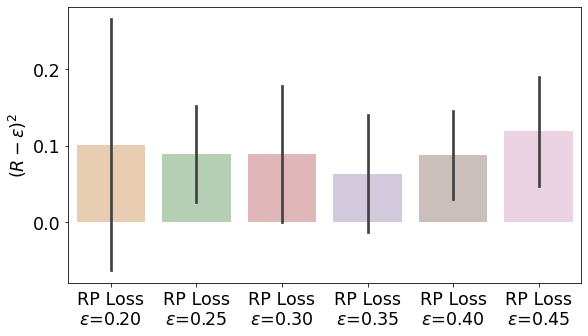

In [36]:
sns.set_palette(sns.color_palette(color_list[1:]))
plt.figure(figsize=(8.5,5))
ax = sns.barplot(x='name',y='rarity-alpha',data=df_final[df_final.alpha!=.1],ci='sd',alpha=.4)
# ax = sns.boxplot(x='name',y='rarity-alpha',data=df_final[df_final.alpha!=.1])
# plt.xticks(np.arange(5),[r'$\alpha$'+'={:.2f}'.format(.2)]+['={:.2f}'.format(ratio) for ratio in ratio_of_pos_to_negs[2:]])
plt.ylabel(r'$(R - \epsilon)^2$')
plt.xlabel('')
plt.tight_layout()
plt.savefig('../data/images/rarity_alpha1.png')
plt.show()

<AxesSubplot:xlabel='name', ylabel='consistency'>

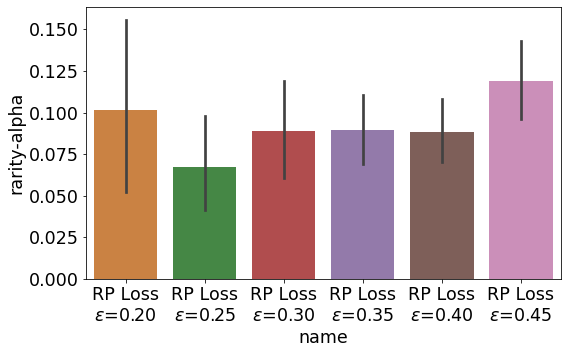

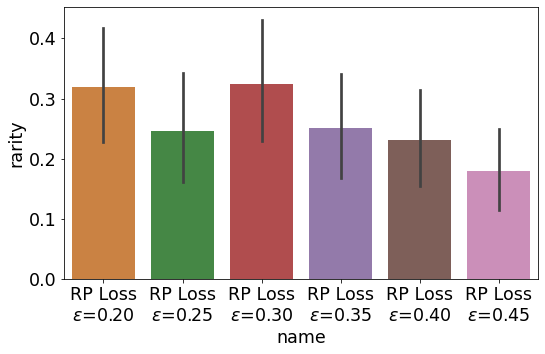

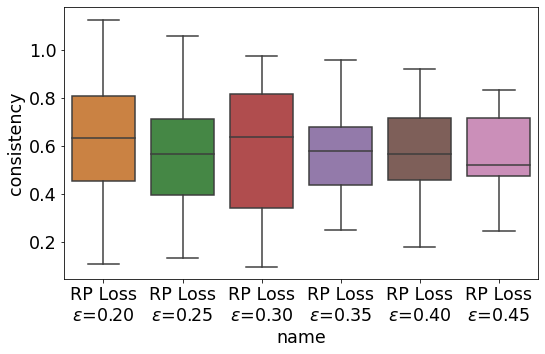

In [38]:
plt.figure(figsize=(8.5,5))
sns.barplot(x='name',y='rarity-alpha',data=df_final[df_final.alpha!=.1])
plt.figure(figsize=(8.5,5))
sns.barplot(x='name',y='rarity',data=df_final[df_final.alpha!=.1])
plt.figure(figsize=(8.5,5))
sns.boxplot(x='name',y='consistency',data=df_final[df_final.alpha!=.1])